In [1]:
from All_functions_simulation_univariate import * 
from All_Functions_FF import my_plot 
from sklearn.linear_model import QuantileRegressor

In [2]:
##################### Data preparation ###################

data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)


# monthly data
index_1927 = data["Year"].to_list().index(1927)
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

In [3]:
################################ MKT VS HML #####################################

##################### Making (X, Y) ###########################

X_axis = "MKT"
Y_axis = "HML"
X = MKT_te
Y = HML_te


Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, method = 'midpoint')
Q3 = np.percentile(Y, 75, method = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]
print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])


train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])


By removing outliers w.r.t y, the number of data being removed is  65


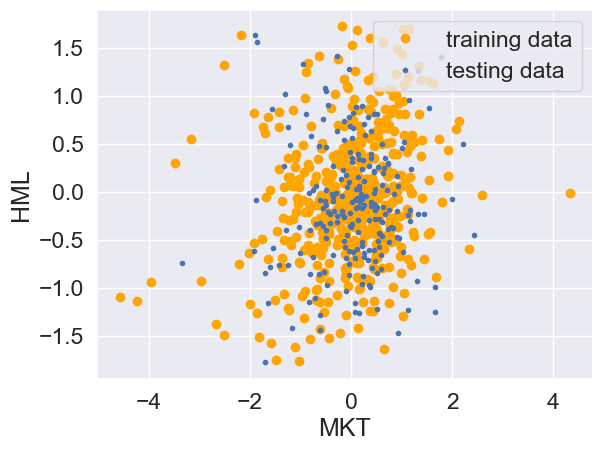

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


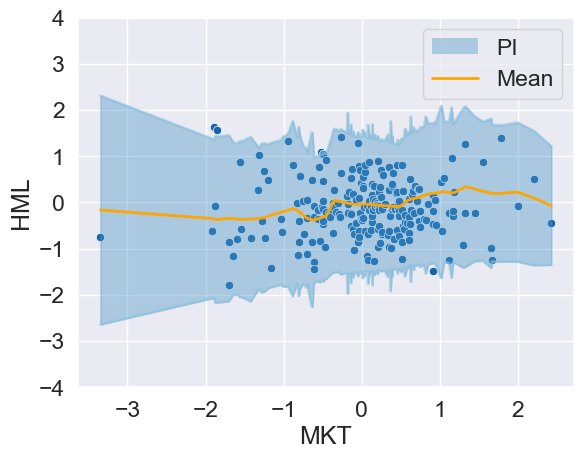

The overall coverage is 0.9771689497716894
The mean bandwidth for testing data is 2.325312221549464
The median bandwidth for testing data is 2.2187802949357676


In [6]:
########################### UTOPIA #########################

X_pre = train_data[:500,0].reshape(-1,1)
Y_pre = train_data[:500,1].reshape(-1,1)

X_opt = train_data[500:700,0].reshape(-1,1)
Y_opt = train_data[500:700,1].reshape(-1,1)

X_adj = train_data[700:,0].reshape(-1,1)
Y_adj = train_data[700:,1].reshape(-1,1)


X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)



n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

# plot training and testing data
plt.plot(X_pre,Y_pre,'o',color = 'orange',label = 'training data')
plt.plot(X_t,Y_t,'.', label = 'testing data')
plt.xlabel(X_axis)
plt.ylabel(Y_axis)
plt.legend(loc="upper right")
plt.show()


#est_type = "NN2"
M_pre, M_opt, M_adj, M_t = mean_est("NN2", X_pre,Y_pre,X_opt,X_adj,X_t)
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t, 5, "RF")

quantile = [0.05,0.35,0.65,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
E_t = E_t.T

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

alpha = 0.05
delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)

V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

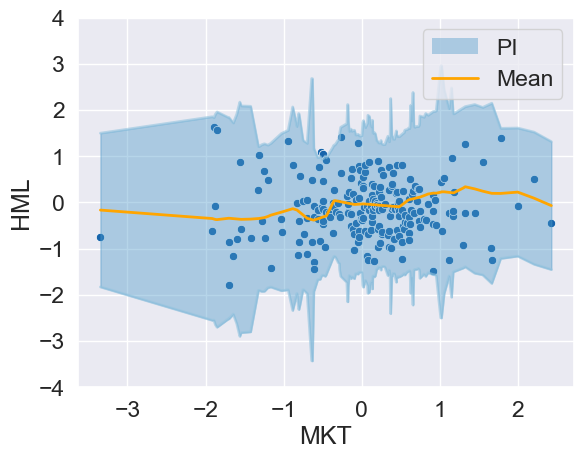

The overall coverage is 0.9908675799086758
The mean bandwidth for testing data is 2.780895913867598
The median bandwidth for testing data is 2.420635848610708


In [7]:
######################## Variance adjusted Split CF #################

X_mean = train_data[:500,0].reshape(-1,1)
Y_mean = train_data[:500,1].reshape(-1,1)

X_res = train_data[500:,0].reshape(-1,1)
Y_res = train_data[500:,1].reshape(-1,1)

X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) 
input_dim = X_mean.shape[1]
model = NN2(input_size=input_dim, output_size=1).to(device)
criterion=nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1000):
    inputs=Variable(torch.from_numpy(X_mean))
    labels=Variable(torch.from_numpy(Y_mean))
    optimizer.zero_grad()
    outputs=model(inputs.float())
    loss=criterion(outputs.float(), labels.float())
    loss.backward()
    optimizer.step()

    
Y_mean_hat = model(torch.from_numpy(X_mean).float())
Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

Y_res_hat = model(torch.from_numpy(X_res).float())
Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

Y_test_hat = model(torch.from_numpy(X_test).float())
Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]


########################### RF based conditional variance estimator ##########################

var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
#var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
var_model.fit(X_mean, resid_mean ** 2)

var_mean_hat = var_model.predict(X_mean)
var_res_hat = var_model.predict(X_res)
var_test_hat = var_model.predict(X_test)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# ########################### NN1 based conditional variance estimator ##########################

# input_dim = X_mean.shape[0]
# X = X_mean.reshape(-1,)
# Y = resid_mean ** 2
# Y = Y.reshape(-1,)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42) 
# model = NN1(input_size=input_dim, output_size=1).to(device)
# criterion=nn.MSELoss()
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# for epoch in range(1000):
#     #convert numpy array to torch Variable
#     inputs=Variable(torch.from_numpy(X))
#     labels=Variable(torch.from_numpy(Y))

#     #clear gradients wrt parameters
#     optimizer.zero_grad()

#     #Forward to get outputs
#     outputs=model(inputs.float())

#     #calculate loss
#     loss=criterion(outputs.float(), labels.float())

#     #getting gradients wrt parameters
#     loss.backward()

#     #updating parameters
#     optimizer.step()

    
# var_res_hat = model(torch.from_numpy(X_res).float()).detach().cpu().numpy().reshape(-1,1)
# var_test_hat = model(torch.from_numpy(X_test).float()).detach().cpu().numpy().reshape(-1,1)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,Y_test_hat,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])